# Exercise 9 : Graph-based SLAM

The goal of this assignment is to implement a least-squares based method to address the SLAM problem in its graph-based formulation as explained in the lecture.

We will consider 2D poses $(x, y, \theta)$ of the robot and 2D landmarks $(x_l, y_l)$ as the unknowns in our SLAM problem. The data is provided as a graph structure containing nodes (poses and landmarks) and constraints between these nodes (i.e pose-pose and pose-landmark). These datasets are stored as `dataset.g2o` text files. You are provided with the following datasets (see `data` folder), each of which represents the measurements of one SLAM problem.
1. `simulation-pose-pose.g2o`: simulated measurements containing pose-pose constraints only  
2. `simulation-pose-landmark.g2o`: simulated measurements containing both pose-pose and pose-landmark constraints
3. `intel.g2o`: real world measurements containing pose-pose constraints only
4. `dlr.g2o`: real world measurements containing both pose-pose and pose-landmark constraints

To get started with this task, we provide some Python code which will help in loading the graph structure, visualize it and other functions that you may need. We also provide additional notes `graph-slam-notes.pdf` which explains the Jacobian computations in detail.

## Task 2.0 Understanding the graph structure

Each graph consists of a set of nodes (or vertices) and edges that connect these nodes. As discussed in the lecture, the nodes correspond to the unknowns of the least-squares SLAM, whereas the edges correspond to the constraints obtained from the measurements.  In this assignment, the graph has the following types of nodes and edges:

1. Nodes:

    `VERTEX_SE2`: These nodes represent the 2D pose of the robot $(x, y, \theta)$

    `VERTEX_XY`: These nodes represent the 2D location of the landmark $(x_l, y_l)$
    
2. Edges:

    `EDGE_SE2`: These edges represent a constraint between two VERTEX_SE2 nodes. We refer to these edges as pose-pose constraints.
    
    `EDGE_SE2_XY`: These edges represent a constraint between a VERTEX_SE2 node and a VERTEX_XY node. We refer these edges as pose-landmark edge.
    

In our code, we represent the graph as a class with the following attributes:
1. `nodes`: A dictionary of nodes where the information of each `node` can be accessed with `nodeId` as a key. Each `node` has a unique `nodeId`. This node can be either `VERTEX_SE2` or `VERTEX_XY`. If node has a dimension of 3, it represents the pose the robot (`VERTEX_SE2`). If the node has a dimension of 2, it represents the location of landmark (`VERTEX_XY`).
  
    
2. `edges`: A list of all the `edges` in the graph where each `edge` has the following attributes:

`Type`: The type is 'P' if the constraint is a pose-pose constraint (`EDGE_SE2`), whereas it is 'L' of it is a pose-landmark constraint (`EDGE_SE2_XY`).
`fromNode`: `nodeId` of the node from which the edge originates from.
`toNode`: `nodeId` of the node to which the edge terminates to.
`measurement`: The measurement corresponding to the edge.
`information`: The corresponding information matrix for the edge constraint.
    
3. `x`: All the unknowns (node variables) are stacked into a vector. This should be used for updating the state after each iteration of the optimization.

4. `lut`: This is a lookup table (implemented as a dictionary in Python). `lut[nodeId]` provides the starting location of the variables of the node with id `nodeId`.

Go through the examples in the cell below to understand how to work with the graph structure. Ensure that you understand how the graph is organized. This will be neccessary to solve all the tasks in the assignment.

Note: you may need to restart the kernel to use updated packages.
Loaded graph with 77 nodes and 297 edges
Loaded graph with 77 nodes and 297 edges
Node 128 = [ 0.378644 -0.23988  -0.0333  ] is a VERTEX_SE2 node
Node 128 from the state vector = [ 0.378644 -0.23988  -0.0333  ]
Node 1 = [ 8.76682 -2.35679] is a VERTEX_XY node
Node 1 from the state vector = [ 8.76682 -2.35679]
Edge 0 = Edge(Type='P', fromNode=100, toNode=101, measurement=array([ 0.112639,  0.023666, -1.57066 ], dtype=float32), information=array([[ 100.,    0.,    0.],
       [   0.,  100.,    0.],
       [   0.,    0., 1000.]], dtype=float32)) is a pose-pose constraint
Edge 1 = Edge(Type='L', fromNode=101, toNode=4, measurement=array([0.050648, 0.357701], dtype=float32), information=array([[100.,   0.],
       [  0., 100.]], dtype=float32)) is a pose-landmark constraint



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Se227140\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


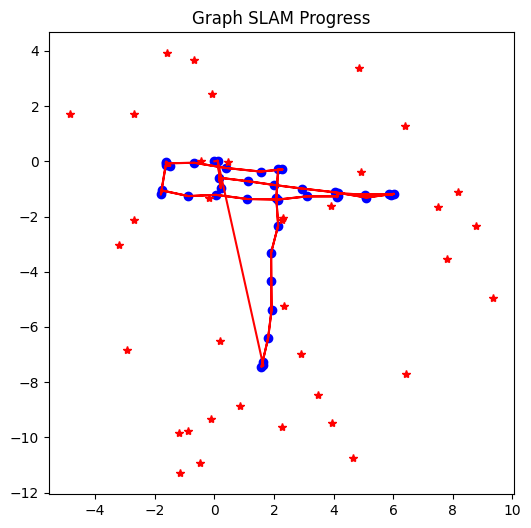

In [3]:
%pip install scipy
import ex9 as ex
%matplotlib inline

# load a dataset
filename = 'data/simulation-pose-landmark.g2o'
graph = ex.read_graph_g2o(filename)

# visualize the dataset
ex.plot_graph(graph)
print('Loaded graph with {} nodes and {} edges'.format(len(graph.nodes), len(graph.edges)))

# print information for the two types of nodes
nodeId = 128
print('Node {} = {} is a VERTEX_SE2 node'.format(nodeId, graph.nodes[nodeId]))

# access the state vector using the lookup table
fromIdx = graph.lut[nodeId]
print('Node {} from the state vector = {}'.format(nodeId,graph.x[fromIdx:fromIdx+3]))

nodeId = 1
print('Node {} = {} is a VERTEX_XY node'.format(nodeId, graph.nodes[nodeId]))

# access the state vector using the lookup table
fromIdx = graph.lut[nodeId]
print('Node {} from the state vector = {}'.format(nodeId, graph.x[fromIdx:fromIdx+2]))

# print information for two types of edges
eid = 0
print('Edge {} = {} is a pose-pose constraint'.format(eid, graph.edges[eid]))

eid = 1
print('Edge {} = {} is a pose-landmark constraint'.format(eid, graph.edges[eid]))

## Task 1.2.1 Computing total error. [5]

In this task, you have implement the function  `compute_global_error` function  for computing the current error value for a graph with constraints. Compute this error for all the four datasets and print the results.


## This script processes multiple **graph-based SLAM datasets** stored in `.g2o` format. It iterates through a list of filenames, checking for their existence before reading the graph structure using `read_graph_g2o`. Then, it computes and prints the **global error**, which measures the inconsistency in the graph, helping to evaluate the accuracy of SLAM optimization.

In [5]:
import os
import ex9 as ex
%matplotlib inline

# Helper functions
# Function to check if the file exists
def check_file_exists(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: File '{filepath}' not found. Check the file path.")

# Function to load the graph and check the number of edges
def load_graph_and_validate_edges(filename, min_edges=2):
    # Load the graph
    graph = ex.read_graph_g2o(filename)

    # Validate if the graph has enough edges
    if len(graph.edges) < min_edges:
        raise IndexError("Error: Not enough edges in the graph. Ensure the dataset is correct.")
    
    return graph

# List of filenames
FILENAMES = [
    'data/simulation-pose-pose.g2o',
    'data/simulation-pose-landmark.g2o',
    'data/intel.g2o',
    'data/dlr.g2o'
]

def compute_and_print_error(filename):
    """Reads a graph file and computes its global error."""
    if not os.path.exists(filename):
        print(f"Error: File '{filename}' not found. Check the file path.")
        return
    
    graph = ex.read_graph_g2o(filename)
    error = ex.compute_global_error(graph)
    print(f"{filename} global error: {error}\n")

"""Processes each file in the FILENAMES list."""
for file in FILENAMES:
    compute_and_print_error(file)

Loaded graph with 400 nodes and 1773 edges
data/simulation-pose-pose.g2o global error: 138862240.5440231

Loaded graph with 77 nodes and 297 edges
data/simulation-pose-landmark.g2o global error: 461709.04414961155

Loaded graph with 1728 nodes and 4830 edges
data/intel.g2o global error: 1795139.0275211956

Loaded graph with 3873 nodes and 17605 edges
data/dlr.g2o global error: 4382432947.035006



## 1.2.2 Linearization of a Pose-Pose constraint [5]

Since the constraint described by the edge between two pose nodes is non-linear, you need to linearize it solve the least-squares optimization. The function `linearize_pose_pose_constraint` computes the error and the Jacobian for pose-pose constraint. It takes as input:
   
1. x1 : 3x1 vector
     $(x,y,\theta)$ of the first robot pose
2. x2 : 3x1 vector
     $(x,y,\theta)$ of the second robot pose
3. z :  3x1 vector
     $(x,y,\theta)$ of the measurement

and returns

1. e  : 3x1
     error of the constraint
2. A  : 3x3
     Jacobian wrt x1
3. B  : 3x3
     Jacobian wrt x2

Implement the `linearize_pose_pose_constraint` function and verify that it is correct.

**Hint** : You can verify the Jacobian computation by comparing against a numerically Jacobian for your test data.




###  This script processes a **graph-based SLAM dataset** in `.g2o` format, focusing on **pose-pose constraints**. It reads the graph, verifies the presence of edges, and selects the first edge to compute **error and Jacobians** using `linearize_pose_pose_constraint`. This helps in refining SLAM optimization by analyzing how well the constraints fit the estimated poses.

In [6]:
import ex9 as ex
%matplotlib inline

# Define the path to the graph file
filename = 'data/simulation-pose-landmark.g2o'

# Function to process the pose-pose constraint for a selected edge
def process_pose_pose_constraint(graph, edge):
    if edge.Type != 'P':
        print("The selected edge is not a pose-pose constraint.")
        return

    # Get the node indices using the lookup table
    from_idx = graph.lut.get(edge.fromNode, None)
    to_idx = graph.lut.get(edge.toNode, None)

    # Validate the indices
    if from_idx is None or to_idx is None:
        raise ValueError("Error: Node indices not found in lookup table.")

    # Extract the node states
    x1 = graph.x[from_idx:from_idx + 3]
    x2 = graph.x[to_idx:to_idx + 3]

    # Get the measurement and information matrix for the edge
    z = edge.measurement

    # Compute the error vector and Jacobians
    error_vector, jacobian_A, jacobian_B = ex.linearize_pose_pose_constraint(x1, x2, z)

    # Print the results
    print("Error Vector (e):\n", error_vector)
    print("Jacobian A:\n", jacobian_A)
    print("Jacobian B:\n", jacobian_B)


# Check file existence
check_file_exists(filename)

# Validate edges in the graph
graph = load_graph_and_validate_edges(filename, 5)

# Select the first edge for processing
edge = graph.edges[0]

# Process the pose-pose constraint for the selected edge
process_pose_pose_constraint(graph, edge)


Loaded graph with 77 nodes and 297 edges
Error Vector (e):
 [0. 0. 0.]
Jacobian A:
 [[-1.36331713e-04  1.00000000e+00  1.12642229e-01]
 [-1.00000000e+00 -1.36331713e-04  2.36506437e-02]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
Jacobian B:
 [[ 1.36331713e-04 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.36331713e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 1.2.3 Linearization of a Pose-Landmark constraint [5]

Since the constraint described by the edge between a pose and landmark node is non-linear, you need to linearize it solve the least-squares optimization. The function `linearize_pose_landmark_constraint` computes the error and the Jacobian for pose-landmark constraint. It takes as input:

    x : 3x1 vector
        (x,y,theta) og the robot pose
    l : 2x1 vector
        (x,y) of the landmark
    z : 2x1 vector
        (x,y) of the measurement
    
and returns:

    e : 2x1 vector
        error for the constraint
    A : 2x3 Jacobian wrt x
    B : 2x2 Jacobian wrt l
    
Implement the `linearize_and_solve` function and verify that it is correct.

**Hint** : You can verify the Jacobian computation by comparing against a numerically Jacobian for your test data.

### In this  **pose-landmark constraints** in graph-based SLAM. It models the relationship between a robot’s estimated pose and observed landmarks using error functions and Jacobians. The error function quantifies the discrepancy between predicted and observed landmark positions, while the Jacobians describe the sensitivity of this error with respect to both the robot's pose and the landmark’s position. The optimization step refines the pose estimates by solving a linearized system, ensuring consistency between measurements and the underlying map representation.

In [7]:
# Define the file path
filename = 'data/simulation-pose-landmark.g2o'

# Function to compute pose updates
def compute_pose_update(graph):
    dx = ex.linearize_and_solve(graph)
    return dx

# Main execution flow
check_file_exists(filename)
graph = load_graph_and_validate_edges(filename, 2)

# Load the graph from the .g2o file
graph = ex.read_graph_g2o(filename)

# Select a specific edge for processing
edge = graph.edges[1]

# Check if the edge represents a pose-landmark constraint
if edge.Type == 'L':
    # Retrieve node indices from lookup table
    from_idx = graph.lut[edge.fromNode]
    to_idx = graph.lut[edge.toNode]

    # Extract the robot pose (x, y, theta) and landmark position (x, y)
    x = graph.x[from_idx:from_idx + 3]
    l = graph.x[to_idx:to_idx + 2]

    # Extract measurement from the edge
    z = edge.measurement

    # Compute the error vector and Jacobians
    error_vector, jacobian_A, jacobian_B = ex.linearize_pose_landmark_constraint(x, l, z)

    # Print results
    print("Pose-Landmark Constraint:")
    print("Error Vector (e):\n", error_vector)
    print("Jacobian A (w.r.t. robot pose):\n", jacobian_A)
    print("Jacobian B (w.r.t. landmark position):\n", jacobian_B)

# Compute and print the pose update
pose_update = compute_pose_update(graph)
print("Pose Update (dx):\n", pose_update)


Loaded graph with 77 nodes and 297 edges
Loaded graph with 77 nodes and 297 edges
Pose-Landmark Constraint:
Error Vector (e):
 [[7.66575907e-07]
 [7.53587835e-08]]
Jacobian A (w.r.t. robot pose):
 [[-1.36331713e-04  1.00000000e+00  3.57701093e-01]
 [-1.00000000e+00 -1.36331713e-04 -5.06487675e-02]]
Jacobian B (w.r.t. landmark position):
 [[ 1.36331713e-04 -1.00000000e+00]
 [ 1.00000000e+00  1.36331713e-04]]
linearize and build system
Pose Update (dx):
 [ 1.68515639e-01  5.74302298e-01 -5.08815097e-02 -3.67481507e-02
  8.89446041e-01  1.46275341e-01 -5.68207903e-03  8.14458323e-02
  6.83987222e-01  4.90075079e-01 -1.26613733e-01 -4.23900184e-03
  7.70788814e-01 -5.38015178e-03 -1.97203631e-01  2.84720356e-01
  2.50968774e-01  6.64986261e-01  1.81320381e-01 -1.10359593e-01
  1.06496690e+00  1.14687536e-01 -3.59193000e-01  1.43487990e-01
  9.36999434e-02 -1.12452273e-01  2.98404549e-02  2.94201773e-01
  9.71233907e-01  9.64883446e-01  2.90376071e-01  4.79224078e-01
  4.72465277e-01  3.050

## 1.2.4 Building and Solving Linearized System [5]

The `linearize_and_solve` function builds the $H$ and $b$ matrices in order to solve for $dx$ (i.e. change in the unknowns $x$) for one iteration. The function takes as input:

    g : graph at iteration i
    
and returns

    dx : Nx1 vector
        change in the solution for the unknowns x

Implement the `linearize_and_solve` function. Some skeletal code for the function is already provided to you to start with.

### In this **graph-based SLAM optimization**. It begins by reading a dataset that encodes spatial relationships between robot poses and landmarks. The **linearization step** approximates the nonlinear error function using first-order Taylor expansion, making the problem solvable via matrix operations. The solution process iteratively refines the pose estimates by solving a system of equations derived from these approximations, minimizing the overall inconsistency in the map representation. The output represents the computed pose update after one iteration of this optimization process.

In [8]:
# Define the file path
filename = 'data/simulation-pose-landmark.g2o'

# Function to perform linearization and solve the graph
def linearize_and_solve_graph(graph):
    try:
        return ex.linearize_and_solve(graph)
    except Exception as e:
        raise RuntimeError(f"An error occurred during linearization and solving: {e}")

# Main execution flow
try:
    # Read the graph
    graph = ex.read_graph_g2o(filename)

    # Perform linearization and solve
    dx = linearize_and_solve_graph(graph)

    # Print the results
    print(f"Iteration: {dx}")

except Exception as e:
    print(e)

Loaded graph with 77 nodes and 297 edges
linearize and build system
Iteration: [ 1.68515639e-01  5.74302298e-01 -5.08815097e-02 -3.67481507e-02
  8.89446041e-01  1.46275341e-01 -5.68207903e-03  8.14458323e-02
  6.83987222e-01  4.90075079e-01 -1.26613733e-01 -4.23900184e-03
  7.70788814e-01 -5.38015178e-03 -1.97203631e-01  2.84720356e-01
  2.50968774e-01  6.64986261e-01  1.81320381e-01 -1.10359593e-01
  1.06496690e+00  1.14687536e-01 -3.59193000e-01  1.43487990e-01
  9.36999434e-02 -1.12452273e-01  2.98404549e-02  2.94201773e-01
  9.71233907e-01  9.64883446e-01  2.90376071e-01  4.79224078e-01
  4.72465277e-01  3.05073402e-01 -5.59910742e-01  8.80651949e-02
 -1.53273456e-01  4.19638284e-01  2.93943913e-02 -1.07591612e-01
  1.88222149e-01  5.57943591e-01  2.34562923e-02 -1.25892841e-01
  2.64340931e-01  1.47997039e-01  4.68753944e-01 -1.48432437e-01
  1.73823840e-01  5.39289708e-01  6.85485419e-01  6.68341300e-01
 -3.30486912e-02  2.34466468e-01  1.11669503e-01 -2.40677365e-02
 -2.5500737

## 1.2.5 Iterative procedure for solving non-linear least squares [5]

The `run_graph_slam` function iteratively solves the least squares problem and updates the unknowns $x$. The procedure should be terminated if the change in $|dx| < 10^-4$ or the until a maximum number of iterations  (maxIter = 100) is reached.

Implement the function `run_graph_slam` to perform the optimization. Some hints are provided as comments in the function. Test the function on the `simulation-pose-pose.g2o` and `simulation-pose-landmark.g2o` datasets.

# First Simulation `simulation-pose-landmark.g2o`
## measurements containing both pose-pose and pose-landmark constraints


### IN this **graph-based SLAM (Simultaneous Localization and Mapping)** optimization by processing spatial constraints encoded in the dataset. It begins by reading the graph structure, where nodes represent robot poses and landmarks, while edges define relative transformations. The function iteratively refines these estimates using optimization techniques that minimize the error in the spatial relationships. The animation aspect suggests a visualization of the pose adjustments over multiple iterations, illustrating the gradual convergence of the estimated trajectory and landmarks toward a consistent global map representation.

Loaded graph with 77 nodes and 297 edges
linearize and build system
Iteration 0
Step 4.451186503379227
linearize and build system
Iteration 1
Step 0.3553912441872291
linearize and build system
Iteration 2
Step 0.012519613948392468
linearize and build system
Iteration 3
Step 7.786156009648291e-05
linearize and build system
Iteration 4
Step 7.222613724564346e-06
final error 438215.0457735458 



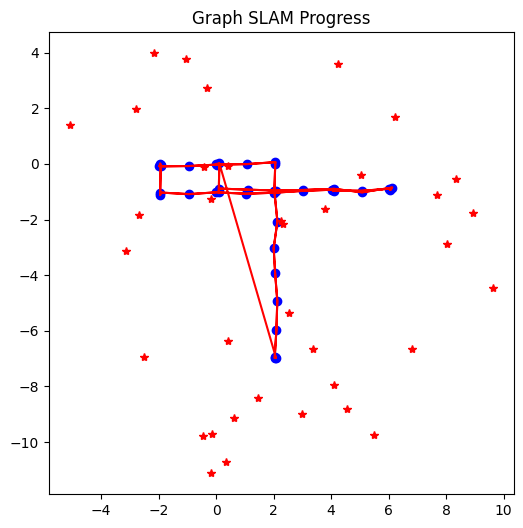

In [9]:
filename = 'data/simulation-pose-landmark.g2o'

g = ex.read_graph_g2o(filename)
spl = ex.run_graph_slam(g, 100)

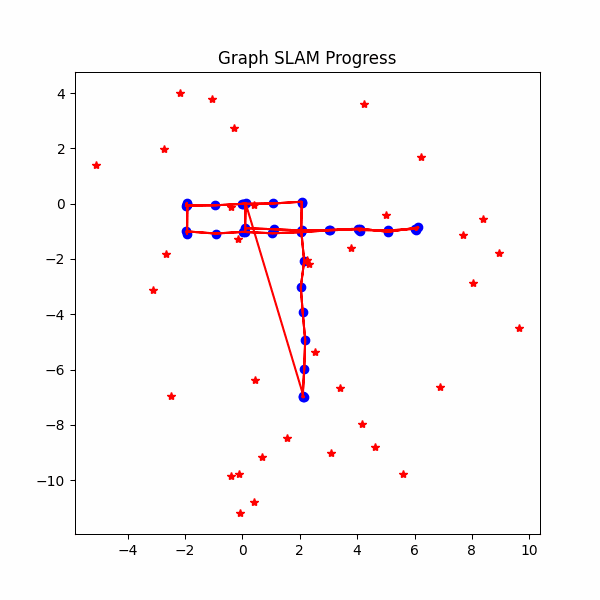

In [10]:
from IPython.display import Image

# Display the GIF in the notebook
Image(filename='graph_slam.gif')

# 2nd Simulation: `simulation-pose-pose.g2o`
## measurements containing pose-pose constraints only


### In this **graph-based SLAM** for a dataset containing **pose-pose constraints**, meaning the optimization process relies on relative transformations between consecutive robot poses. The algorithm iteratively refines the trajectory by minimizing the discrepancy between predicted and measured constraints, effectively correcting drift from odometry errors. By running **Graph SLAM** for multiple iterations, the estimated trajectory aligns more closely with the true motion, improving consistency and reducing accumulated errors in large-scale mapping scenarios.

Loaded graph with 400 nodes and 1773 edges
linearize and build system
Iteration 0
Step 204.83059894138486
linearize and build system
Iteration 1
Step 32.62323555739558
linearize and build system
Iteration 2
Step 5.323746312489162
linearize and build system
Iteration 3
Step 1.4163539475790667
linearize and build system
Iteration 4
Step 0.09571327299738888
linearize and build system
Iteration 5
Step 0.018185058005797672
linearize and build system
Iteration 6
Step 0.0044260023280715145
linearize and build system
Iteration 7
Step 0.0013765484187643698
linearize and build system
Iteration 8
Step 0.00034608292476328065
linearize and build system
Iteration 9
Step 0.00013538980517303206
linearize and build system
Iteration 10
Step 3.4095169897988586e-05
linearize and build system
Iteration 11
Step 1.399451016292911e-05
final error 8269.420009791835 



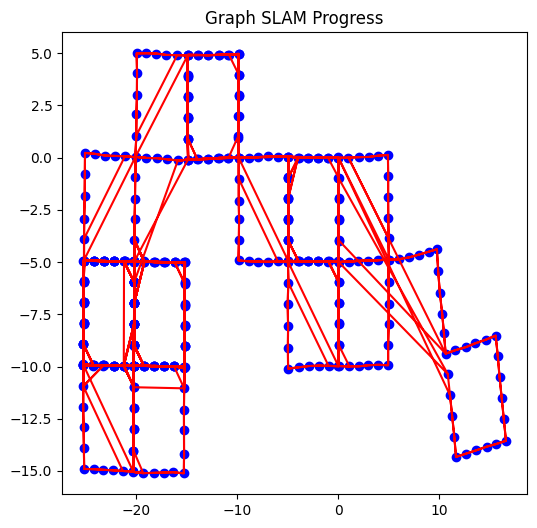

In [11]:
filename = 'data/simulation-pose-pose.g2o'

g = ex.read_graph_g2o(filename)
spp = ex.run_graph_slam(g, 100)

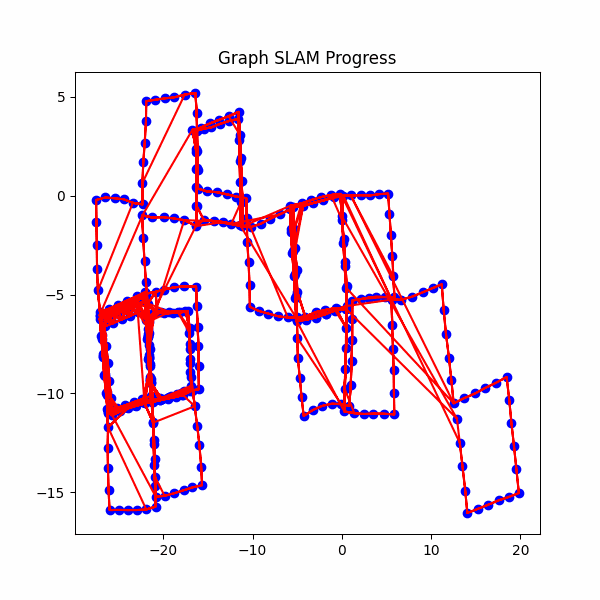

In [12]:
# Display the GIF
Image(filename='graph_slam.gif')

# ` Real world measurements `
# 3rd simulation `dlr.g2o`
## Real world measurements containing both pose-pose and pose-landmark constraints

### In this **Graph SLAM** to the **DLR dataset**, which contains both **pose-pose and pose-landmark constraints**. The optimization process refines the estimated trajectory and landmark positions by minimizing the overall error in the graph. By iterating through the constraints, the algorithm corrects odometry drift, aligns overlapping observations, and improves map consistency. Running multiple iterations enhances the accuracy of the estimated environment, ensuring that both robot poses and landmarks converge to an optimal configuration.

Loaded graph with 3873 nodes and 17605 edges
linearize and build system
Iteration 0
Step 968.1197951627933
linearize and build system
Iteration 1
Step 3189.4895055981196
linearize and build system
Iteration 2
Step 2285.1463813229084
linearize and build system
Iteration 3
Step 1003.8398824784928
linearize and build system
Iteration 4
Step 294.60620105339285
linearize and build system
Iteration 5
Step 67.08789410470045
linearize and build system
Iteration 6
Step 3.2803408497233386
linearize and build system
Iteration 7
Step 0.696261868526544
linearize and build system
Iteration 8
Step 0.01702057816880324
linearize and build system
Iteration 9
Step 0.0016158289973507857
linearize and build system
Iteration 10
Step 0.0006639185690494197
linearize and build system
Iteration 11
Step 0.00026963686695216155
linearize and build system
Iteration 12
Step 0.0005648294009792387
linearize and build system
Iteration 13
Step 0.00021930587295103965
linearize and build system
Iteration 14
Step 0.0004287

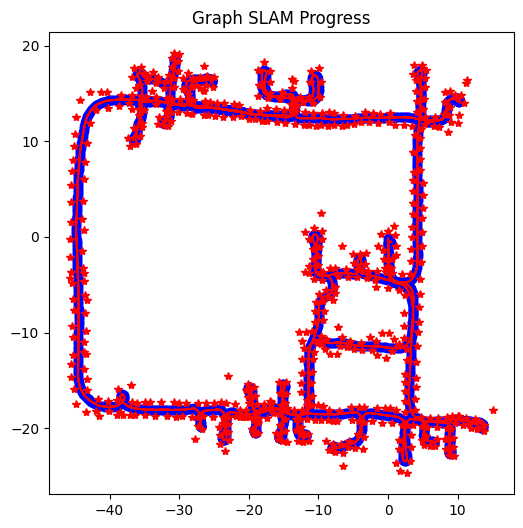

In [13]:
import ex9 as ex

filename = 'data/dlr.g2o'

g = ex.read_graph_g2o(filename)
pppl = ex.run_graph_slam(g, 100)


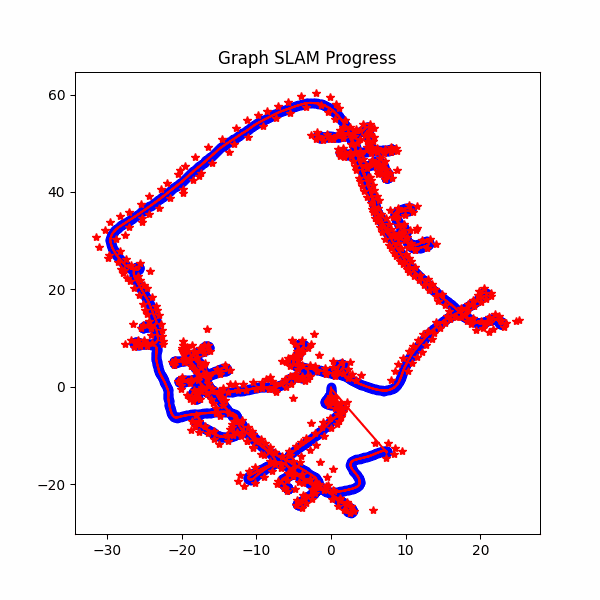

In [14]:
# Display the GIF
Image(filename='graph_slam.gif')

# 4th simualtion `intel.g2o`
## real world measurements containing pose-pose constraints only
  

### In this **Graph SLAM** on the **Intel dataset**, a well-known benchmark for **pose graph optimization**. The dataset consists of robot trajectory data with **pose-pose constraints** obtained from odometry and loop closures. By iterating over the graph structure, the algorithm refines the estimated robot poses, reducing drift and aligning overlapping observations. Running multiple iterations improves the **global consistency** of the trajectory, ensuring a more accurate reconstruction of the environment.

Loaded graph with 1728 nodes and 4830 edges
linearize and build system
Iteration 0
Step 123.93908461119987
linearize and build system
Iteration 1
Step 18.898700456065374
linearize and build system
Iteration 2
Step 0.8351224547875044
linearize and build system
Iteration 3
Step 0.016286849615656004
linearize and build system
Iteration 4
Step 0.00015544160509256064
linearize and build system
Iteration 5
Step 2.1430576829824506e-05
linearize and build system
Iteration 6
Step 1.7300258965777398e-05
final error 359.9960972712533 



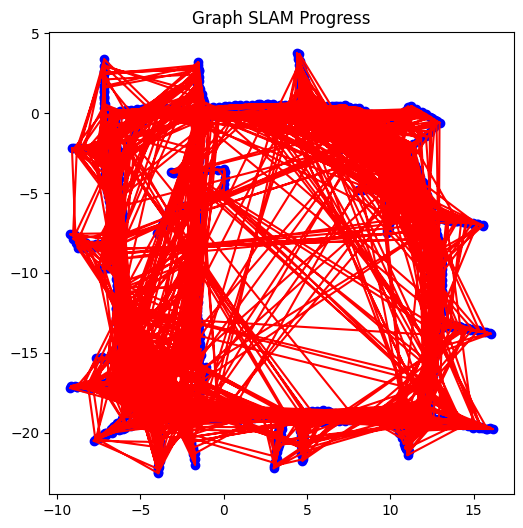

In [15]:
filename = 'data/intel.g2o'

g = ex.read_graph_g2o(filename)
ppc = ex.run_graph_slam(g, 100)

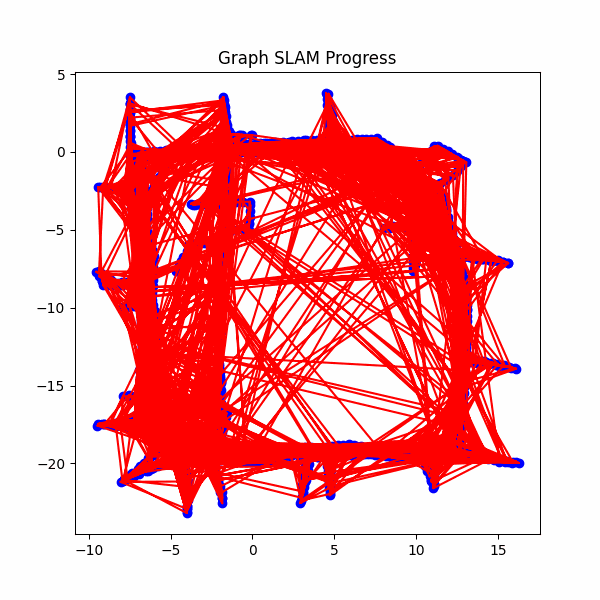

In [16]:
# Display the GIF
Image(filename='graph_slam.gif')

## 1.2.6 Results for different datasets [5]

Evaluate the results of the graph-slam algorithm for all the four datasets.

1. Create a `gif` animation visualing the results after each iteration.
2. Plot the error vs iterations for all the datasets.

Please run your code locally and upload the `gifs` generated from your results in the cell below.

1. `simulation-pose-pose.g2o`: simulated measurements containing pose-pose constraints only  
2. `simulation-pose-landmark.g2o`: simulated measurements containing both pose-pose and pose-landmark constraints
3. `intel.g2o`: real world measurements containing pose-pose constraints only
4. `dlr.g2o`: real world measurements containing both pose-pose and pose-landmark constraints

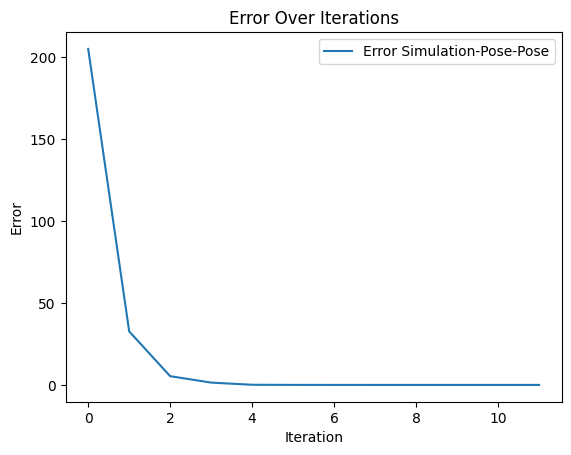

In [17]:
import matplotlib.pyplot as plt

# Plot the error data
plt.plot(spp, label="Error Simulation-Pose-Pose")

# Add labels and title
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error Over Iterations")

# Add a legend
plt.legend()

# Show the plot
plt.show()


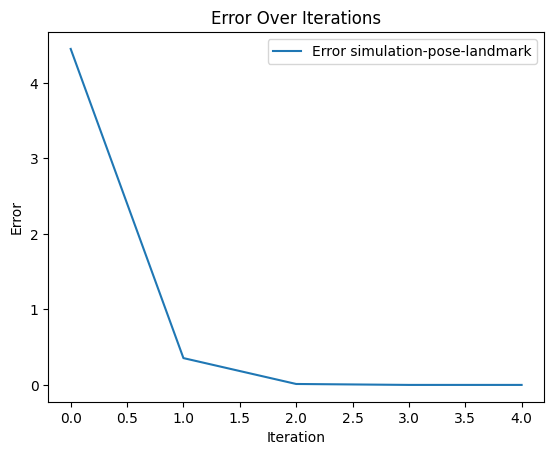

In [18]:
# Plot the error data
plt.plot(spl, label="Error simulation-pose-landmark")

# Add labels and title
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error Over Iterations")

# Add a legend
plt.legend()

# Show the plot
plt.show()

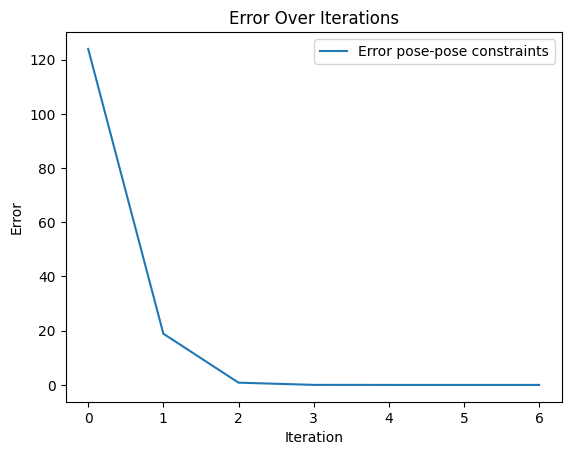

In [20]:
# Plot the error data
plt.plot(ppc, label="Error pose-pose constraints")

# Add labels and title
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error Over Iterations")

# Add a legend
plt.legend()

# Show the plot
plt.show()

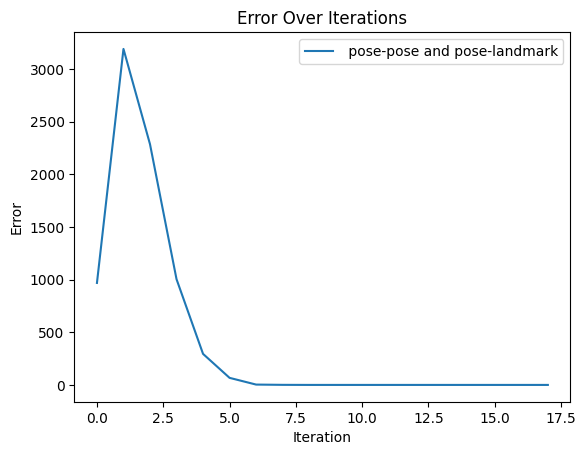

In [17]:
# Plot the error data
plt.plot(pppl, label=" pose-pose and pose-landmark")

# Add labels and title
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error Over Iterations")

# Add a legend
plt.legend()

# Show the plot
plt.show()